In [128]:
import numpy as np
import torch
from matplotlib import pyplot as plt, rcParams
from matplotlib.colors import LogNorm
from models import Classifier, LegendreLoss, Metrics, find_threshold
from matplotlib.cm import get_cmap
from jupyterthemes import jtplot
plt.style.use('dark_background')
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
np.random.seed(42)
rcParams['axes.facecolor'] = 'k'
rcParams["figure.facecolor"] = '#212121'
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.serif"] = "Bitstream Vera Serif"
rcParams["font.family"] = "serif"

my_cmap = get_cmap('viridis')
my_cmap.set_bad(my_cmap.colors[0])

# Generating Toy Data
Generate signal mass from a uniform + gaussian distribution.

Generate background mass from a linear distribution $ ax + b $ (with $ a = \frac{1}{4} $ and $ b = \frac{1}{2} $ ) using inversion transform sampling.

Generate random gaussian variables uncorrelated with mass but slightly different for signal and background.

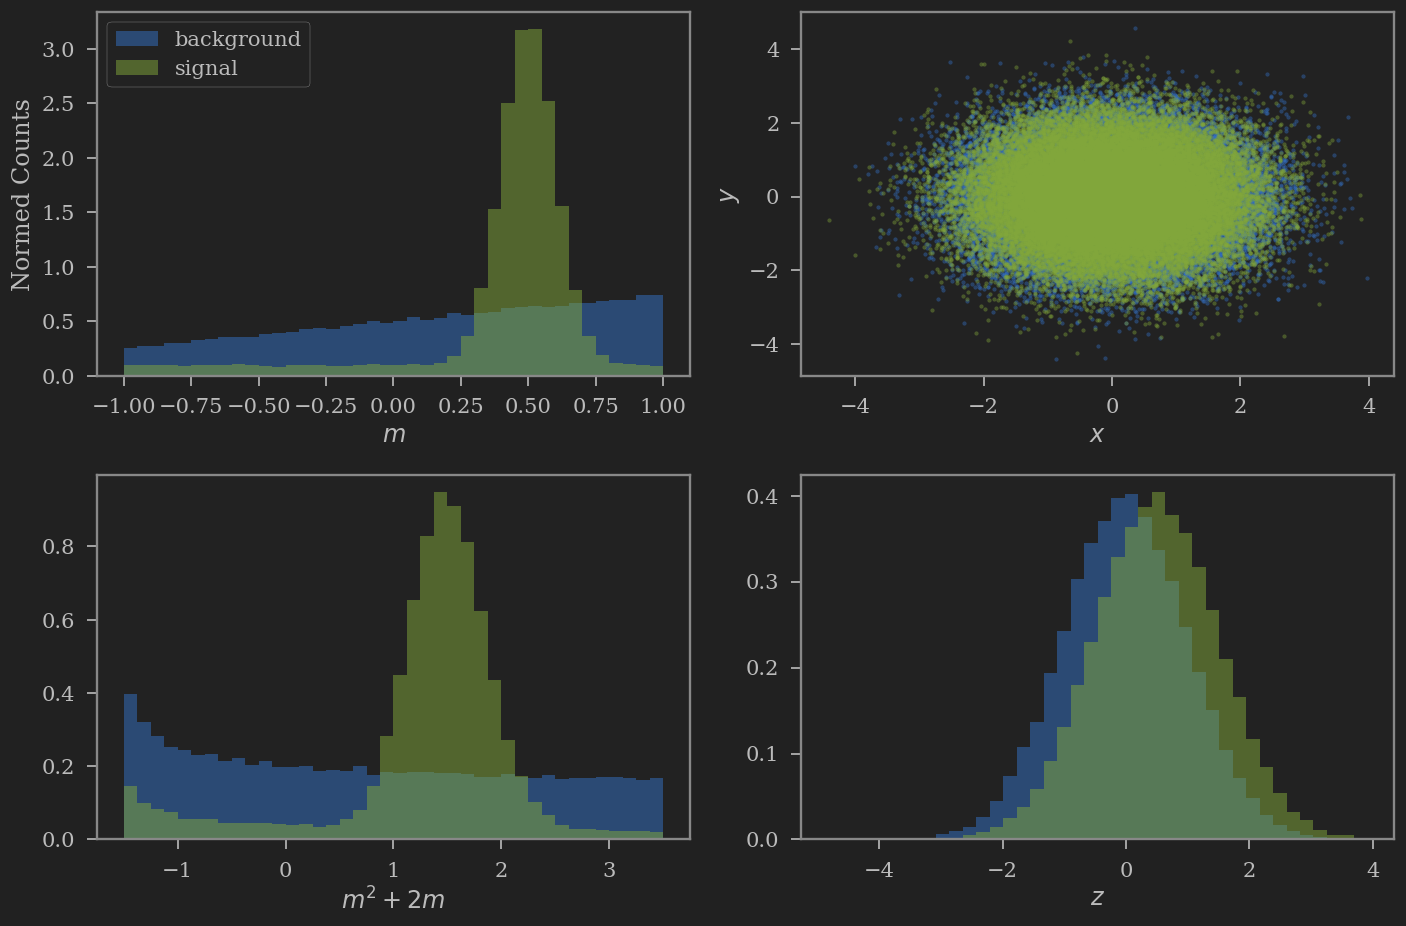

In [98]:
n_s = int(5e4)
n_b = int(5e4)
n_s_gauss_frac = 0.8

a = 1/4 
b = 1/2

u = np.random.uniform(0,1,50000)
u_ = np.random.uniform(0,1,50000)

m_b = - b/(a) + np.sqrt((b-a)**2 + 2*a*u)/(a)
m_s = np.concatenate([np.random.uniform(-1,1,n_s-int(n_s_gauss_frac*n_s)), 
                    np.random.normal(0.5,0.1,size=int(n_s_gauss_frac*n_s))])
m_t = -b/(a) + np.sqrt((b-a)**2 + 2*a*u_)/(a)
m_t.sort()

x_b,y_b  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T
x_s,y_s  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_s).T
x_t,y_t  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T


z_b = np.random.normal(0,1,n_b)
z_s = np.random.normal(0.5,1,n_s)
z_t = np.random.normal(0,1,n_b)

fig ,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(12,8),dpi=120)

_,bins,_ = ax1.hist(m_b,bins=40,density=True,alpha=0.5, label='background')
ax1.hist(m_s,bins=bins,density=True,alpha=0.5,label='signal')
ax1.legend()
ax1.set_xlabel(r"$m$")
ax1.set_ylabel("Normed Counts")

ax2.scatter(x_b,y_b,s=5,alpha=0.4)
ax2.scatter(x_s,y_s,s=5,alpha=0.4)
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$y$")

_,bins,_ = ax3.hist(m_b**2+2.5*m_b,bins=40,density=True,alpha=0.5, label='background')
ax3.hist(m_s**2+2.5*m_s,bins=bins,density=True,alpha=0.5,label='signal')
ax3.set_xlabel(r"$m^2 + 2m$")

_,bins,_ = ax4.hist(z_b,bins=40,density=True,alpha=0.5, label='background')
ax4.hist(z_s,bins=bins,density=True,alpha=0.5,label='signal')
ax4.set_xlabel(r"$z$")

#ax2.set_title("Data")
fig.tight_layout()
plt.savefig("./plots/Data.pdf")
plt.show()

In [99]:
x = np.concatenate([np.stack([m_s,m_s**2+2*m_s,x_s,y_s,z_s],axis=1),
                   np.stack([m_b,m_b**2+2*m_b,x_b,y_b,z_b],axis=1)])

y = np.concatenate([np.ones(m_s.size),np.zeros(m_b.size)])

x_test = np.stack([m_t,m_t**2+2*m_t,x_t,y_t,z_t],axis=1) 
y_test = np.zeros(n_b)
# Shuffling the data
size = y.size
mask = np.arange(size)
np.random.shuffle(mask)

# Train Validation Split
x_train = x[mask][:int(size*0.8)]
y_train = y[mask][:int(size*0.8)]

x_val = x[mask][int(size*0.8):]
y_val = y[mask][int(size*0.8):]

# Torch Tensors
x_train_tensor = torch.from_numpy(x_train).float().view(-1,5)
y_train_tensor = torch.from_numpy(y_train).float().view(-1,1)
x_val_tensor = torch.from_numpy(x_val).float().view(-1,5)
y_val_tensor = torch.from_numpy(y_val).float().view(-1,1)
x_test_tensor = torch.from_numpy(x_test).float().view(-1,5)
y_test_tensor = torch.from_numpy(y_test).float().view(-1,1)

/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


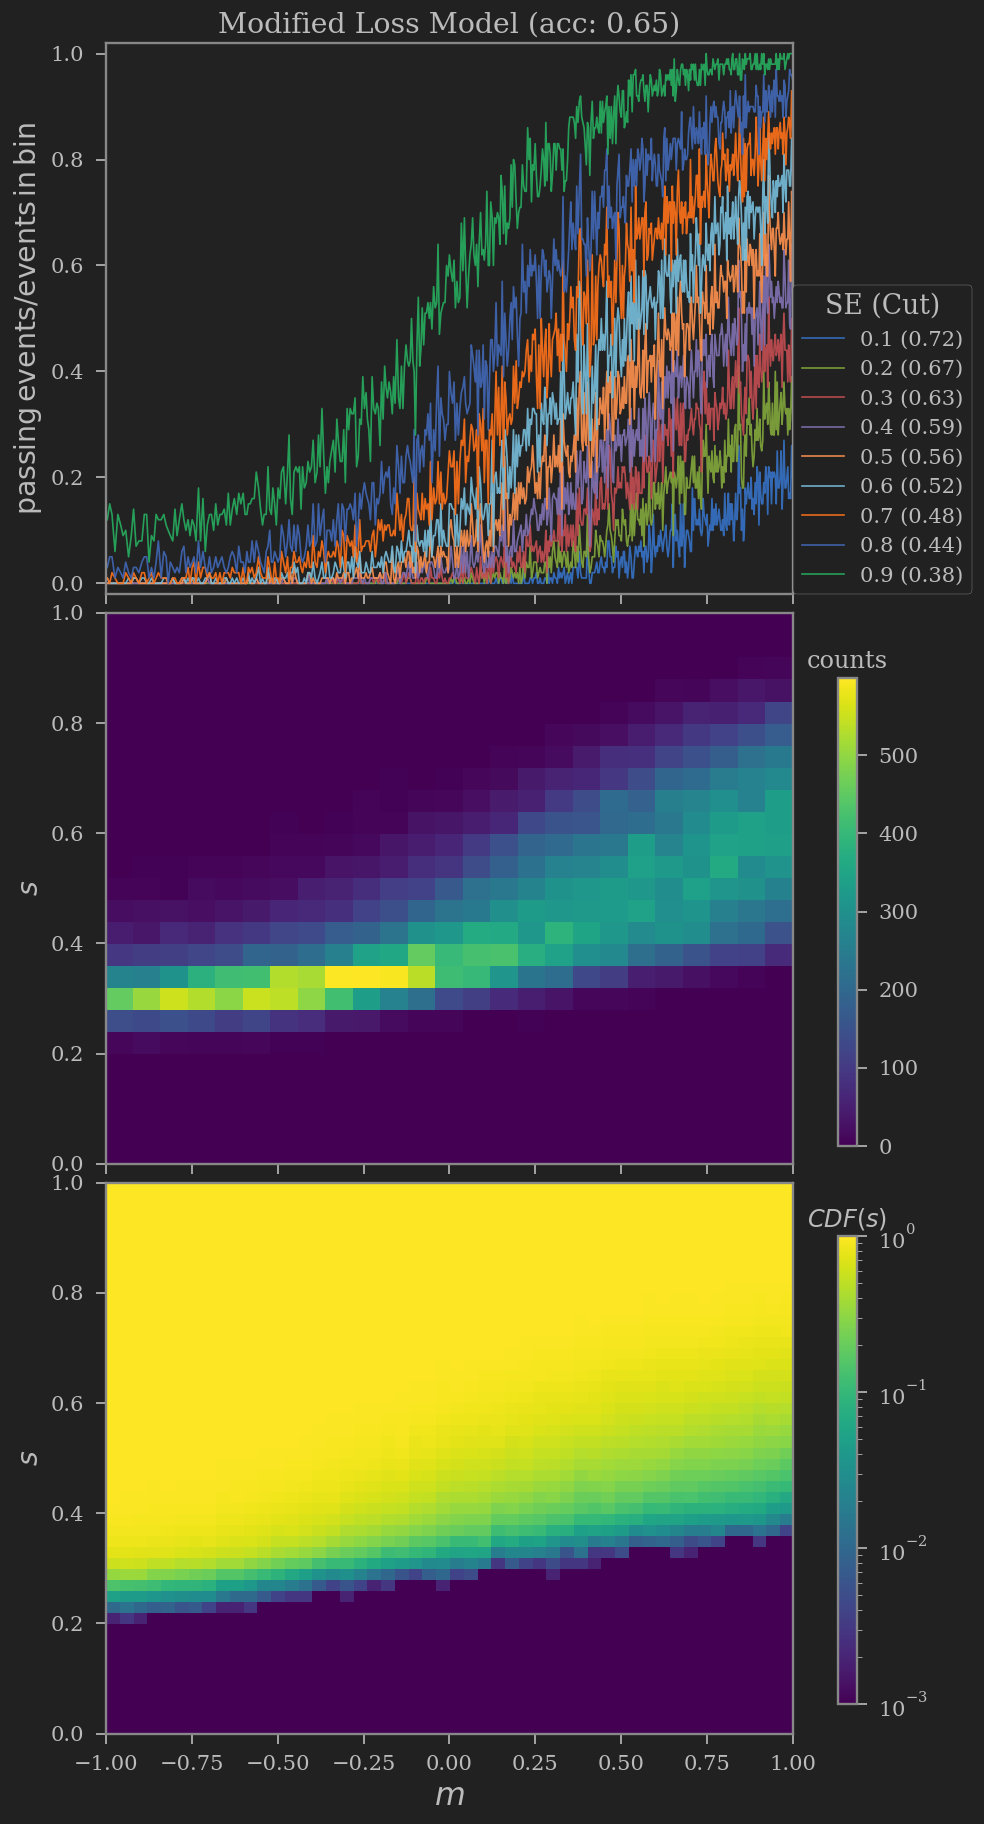

In [129]:
validation_predictions = np.array(model_legendre.yhat_val.tolist()).flatten()
cuts = []
for eff in efficiencies:
    cuts.append(find_threshold(validation_predictions,(y_val==1),eff))


scores = np.array(model_legendre(x_test_tensor[:,1:]).tolist()).reshape(-1,100)
m = m_t.reshape(-1,100).mean(axis=1)
F_s = []
for s in scores.reshape(50,-1):
    density = np.histogram(s,bins=50,range=(0,1))[0]
    F_s.append(np.cumsum(density)/density.sum())
F_s = np.array(F_s).T
fig, [ax1, ax2, ax3]  = plt.subplots(3,1,figsize=[8,5*3],dpi=120,sharex=True)
for j,cut in enumerate(cuts):
    c = f"C{j}" if j!= 6 else f"C11"
    passed = (scores>cut).sum(axis=1)/scores.shape[1]
    ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)

ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=17)
ax1.set_ylim([-0.02,1.02])
ax1.set_title("Modified Loss Model (acc: {:.02})".format(metrics_val_legendre.accs[-1]),fontsize=17)
ax1.legend(loc=(1,0),markerscale=5,title="SE (Cut)",ncol=1)

_,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=25, label="all",cmap='viridis',range=[[-1,1],[0,1]])
cbaxes = fig.add_axes([0.86, 0.37, 0.02, 0.26]) 
cb = plt.colorbar(h,ax=ax2,cax = cbaxes)
cb.ax.set_title("counts")
ax2.set_ylabel(r"$s$",fontsize=17)

im = ax3.imshow(F_s,label="all",origin='lower',extent=[-1,1,0,1],aspect="auto",norm=LogNorm(),cmap=my_cmap)
ax3.set_ylabel(r"$s$",fontsize=17)

cbaxes = fig.add_axes([0.86, 0.06, 0.02, 0.26]) 
cb = plt.colorbar(im,ax=ax3,cax = cbaxes)
cb.ax.set_title(r"$CDF(s)$")
ax3.set_xlabel(r"$m$",fontsize=19)

fig.tight_layout(pad=0)
plt.show()

Epoch:0000/1700 || Train: loss:0.2565, acc:50% || Test: loss: 0.2565, acc:50%
Epoch:0100/1700 || Train: loss:0.2438, acc:60% || Test: loss: 0.2438, acc:60%
Epoch:0200/1700 || Train: loss:0.2348, acc:63% || Test: loss: 0.2348, acc:63%
Epoch:0300/1700 || Train: loss:0.2282, acc:64% || Test: loss: 0.2281, acc:64%
Epoch:0400/1700 || Train: loss:0.2236, acc:65% || Test: loss: 0.2235, acc:64%
Epoch:0500/1700 || Train: loss:0.2197, acc:66% || Test: loss: 0.2196, acc:65%
Epoch:0600/1700 || Train: loss:0.2153, acc:66% || Test: loss: 0.2154, acc:66%
Epoch:0700/1700 || Train: loss:0.2099, acc:68% || Test: loss: 0.2099, acc:68%
Epoch:0800/1700 || Train: loss:0.2042, acc:69% || Test: loss: 0.2042, acc:69%
Epoch:0900/1700 || Train: loss:0.1981, acc:71% || Test: loss: 0.1981, acc:71%
Epoch:1000/1700 || Train: loss:0.1917, acc:73% || Test: loss: 0.1918, acc:73%
Epoch:1100/1700 || Train: loss:0.1857, acc:75% || Test: loss: 0.1858, acc:75%
Epoch:1200/1700 || Train: loss:0.1804, acc:76% || Test: loss: 0.

/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


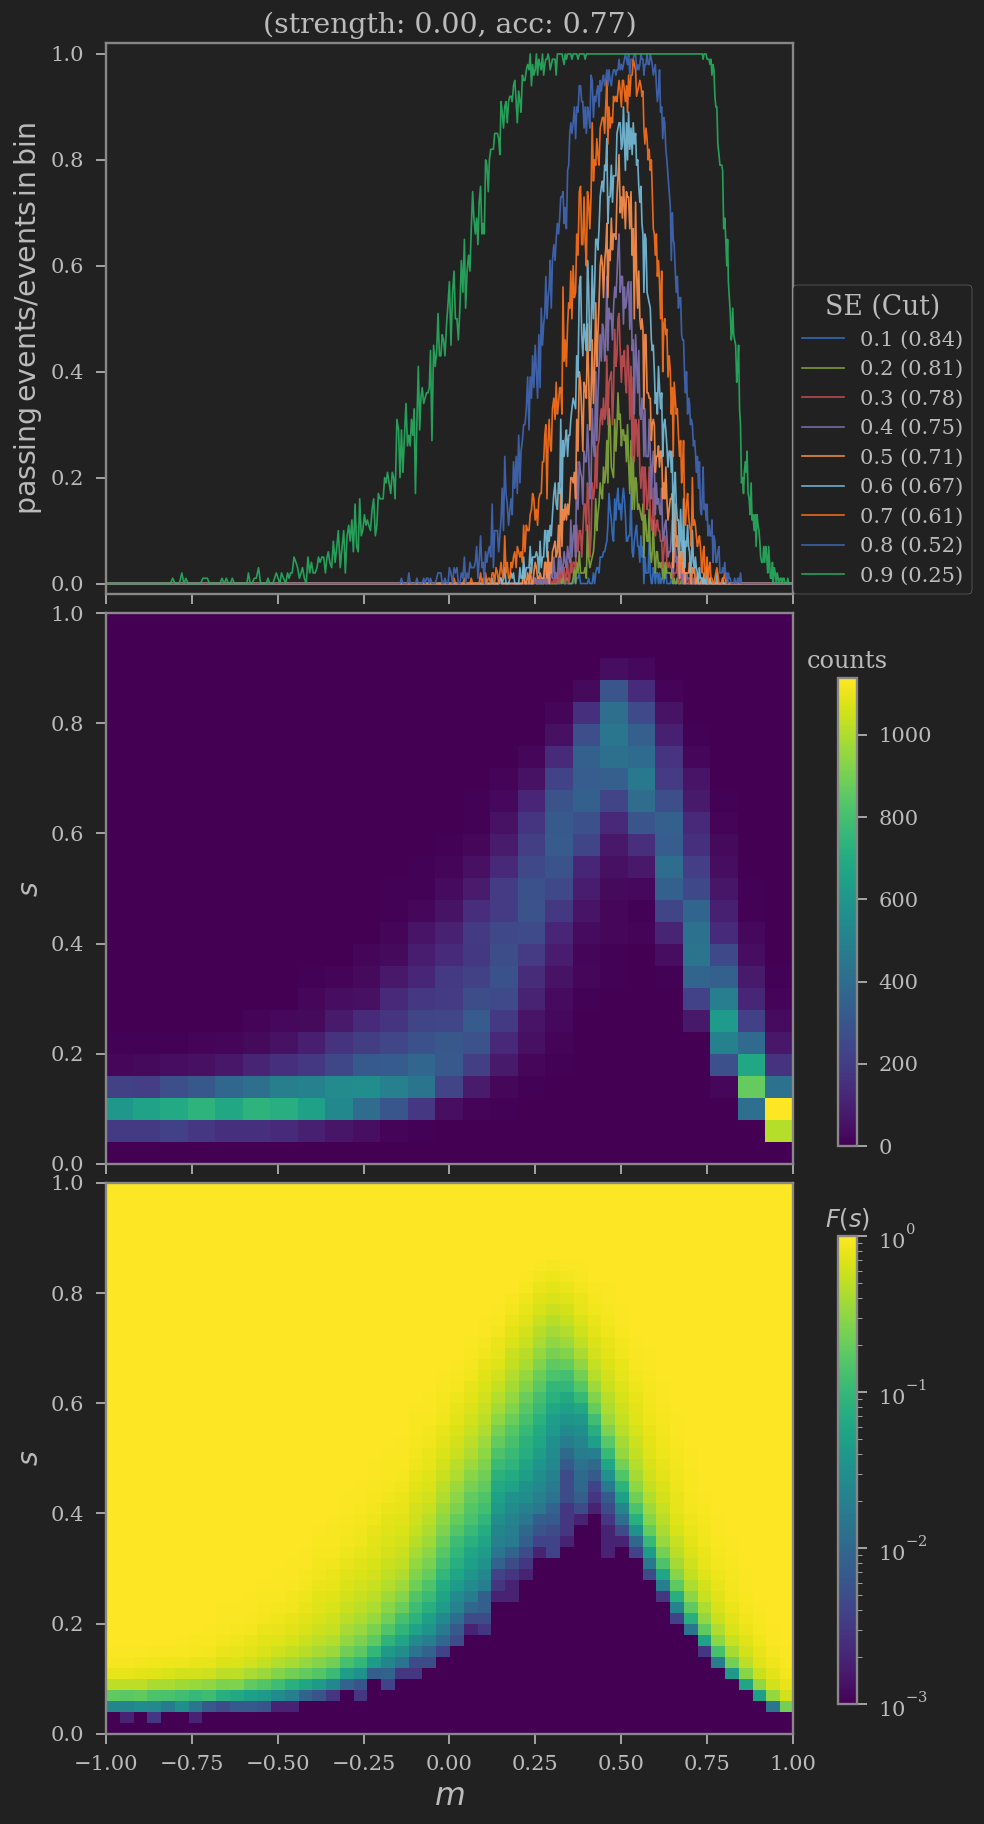

Epoch:0000/1700 || Train: loss:0.1686, acc:50% || Test: loss: 0.2531, acc:50%
Epoch:0100/1700 || Train: loss:0.1650, acc:57% || Test: loss: 0.2477, acc:57%
Epoch:0200/1700 || Train: loss:0.1632, acc:61% || Test: loss: 0.2451, acc:60%
Epoch:0300/1700 || Train: loss:0.1610, acc:63% || Test: loss: 0.2417, acc:63%
Epoch:0400/1700 || Train: loss:0.1579, acc:65% || Test: loss: 0.2370, acc:65%
Epoch:0500/1700 || Train: loss:0.1539, acc:66% || Test: loss: 0.2309, acc:66%
Epoch:0600/1700 || Train: loss:0.1493, acc:67% || Test: loss: 0.2240, acc:67%
Epoch:0700/1700 || Train: loss:0.1448, acc:68% || Test: loss: 0.2173, acc:68%
Epoch:0800/1700 || Train: loss:0.1411, acc:69% || Test: loss: 0.2116, acc:69%
Epoch:0900/1700 || Train: loss:0.1379, acc:70% || Test: loss: 0.2068, acc:69%
Epoch:1000/1700 || Train: loss:0.1350, acc:71% || Test: loss: 0.2025, acc:70%
Epoch:1100/1700 || Train: loss:0.1324, acc:72% || Test: loss: 0.1986, acc:72%
Epoch:1200/1700 || Train: loss:0.1299, acc:73% || Test: loss: 0.

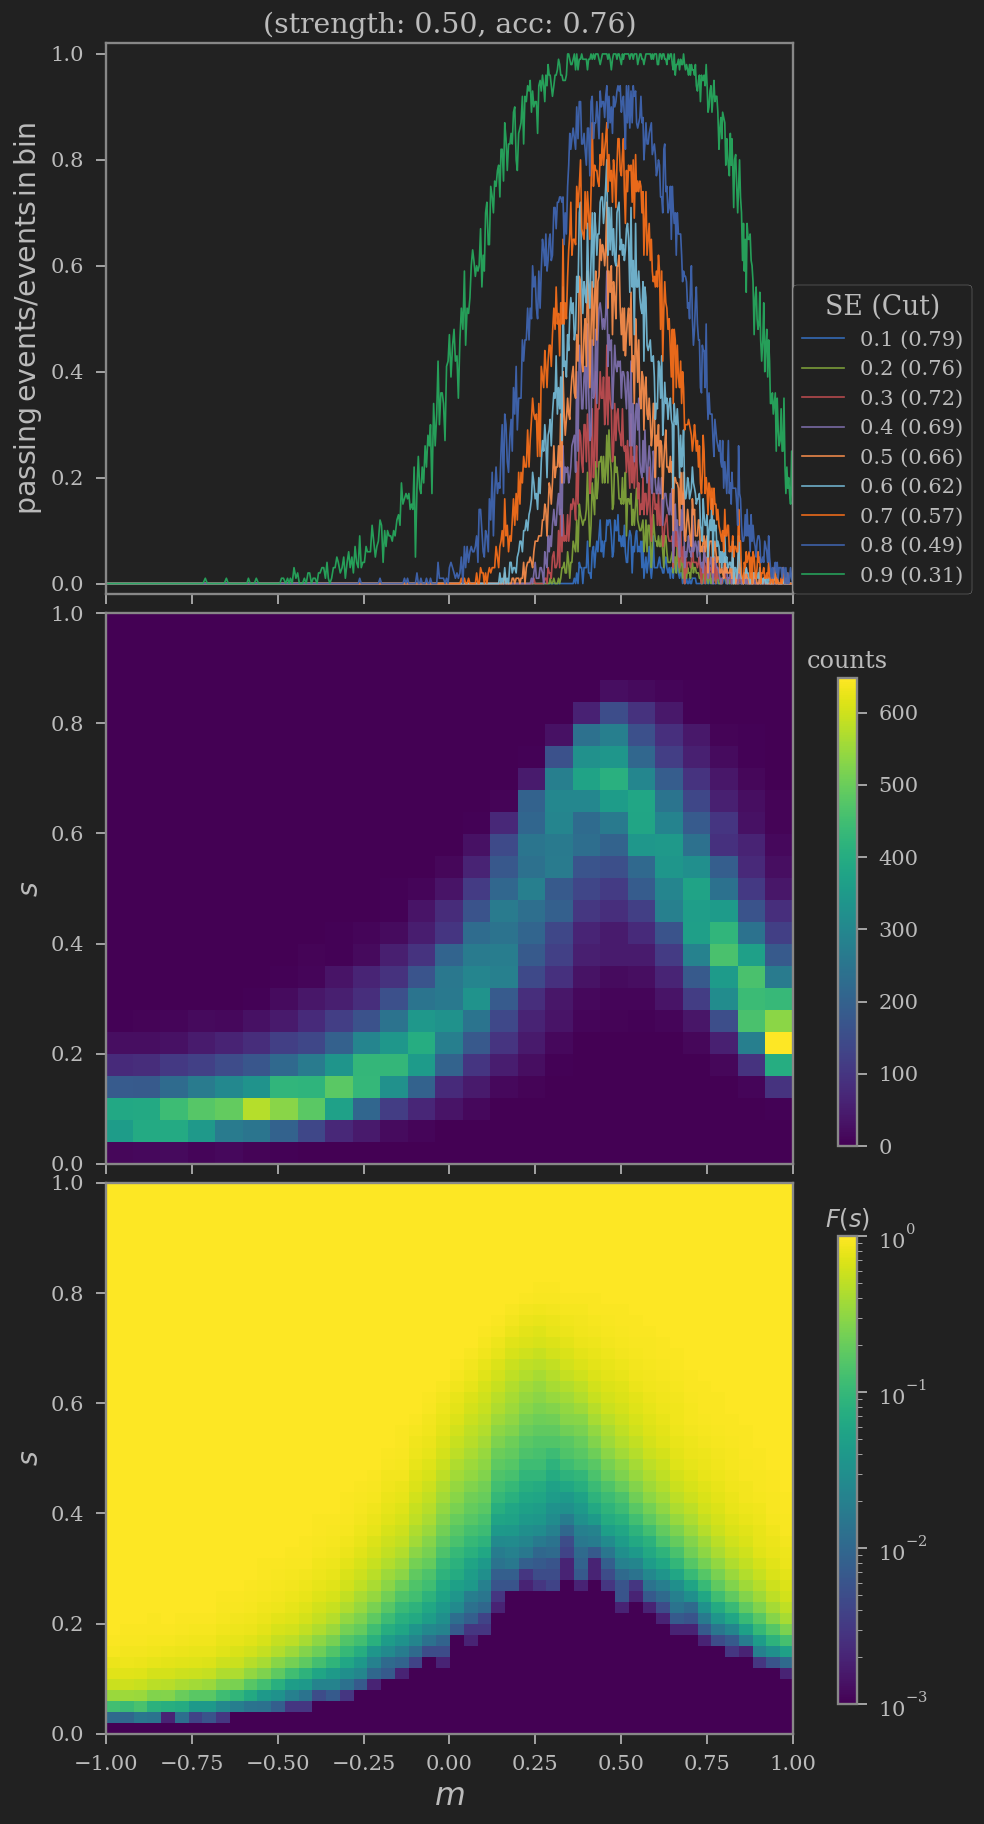

Epoch:0000/1700 || Train: loss:0.1252, acc:50% || Test: loss: 0.2499, acc:50%
Epoch:0100/1700 || Train: loss:0.1214, acc:62% || Test: loss: 0.2428, acc:62%
Epoch:0200/1700 || Train: loss:0.1189, acc:63% || Test: loss: 0.2377, acc:63%
Epoch:0300/1700 || Train: loss:0.1163, acc:64% || Test: loss: 0.2327, acc:64%
Epoch:0400/1700 || Train: loss:0.1141, acc:65% || Test: loss: 0.2283, acc:64%
Epoch:0500/1700 || Train: loss:0.1124, acc:65% || Test: loss: 0.2249, acc:65%
Epoch:0600/1700 || Train: loss:0.1112, acc:65% || Test: loss: 0.2224, acc:65%
Epoch:0700/1700 || Train: loss:0.1103, acc:65% || Test: loss: 0.2206, acc:65%
Epoch:0800/1700 || Train: loss:0.1096, acc:66% || Test: loss: 0.2191, acc:65%
Epoch:0900/1700 || Train: loss:0.1089, acc:66% || Test: loss: 0.2177, acc:66%
Epoch:1000/1700 || Train: loss:0.1082, acc:66% || Test: loss: 0.2164, acc:66%
Epoch:1100/1700 || Train: loss:0.1076, acc:67% || Test: loss: 0.2152, acc:66%
Epoch:1200/1700 || Train: loss:0.1069, acc:67% || Test: loss: 0.

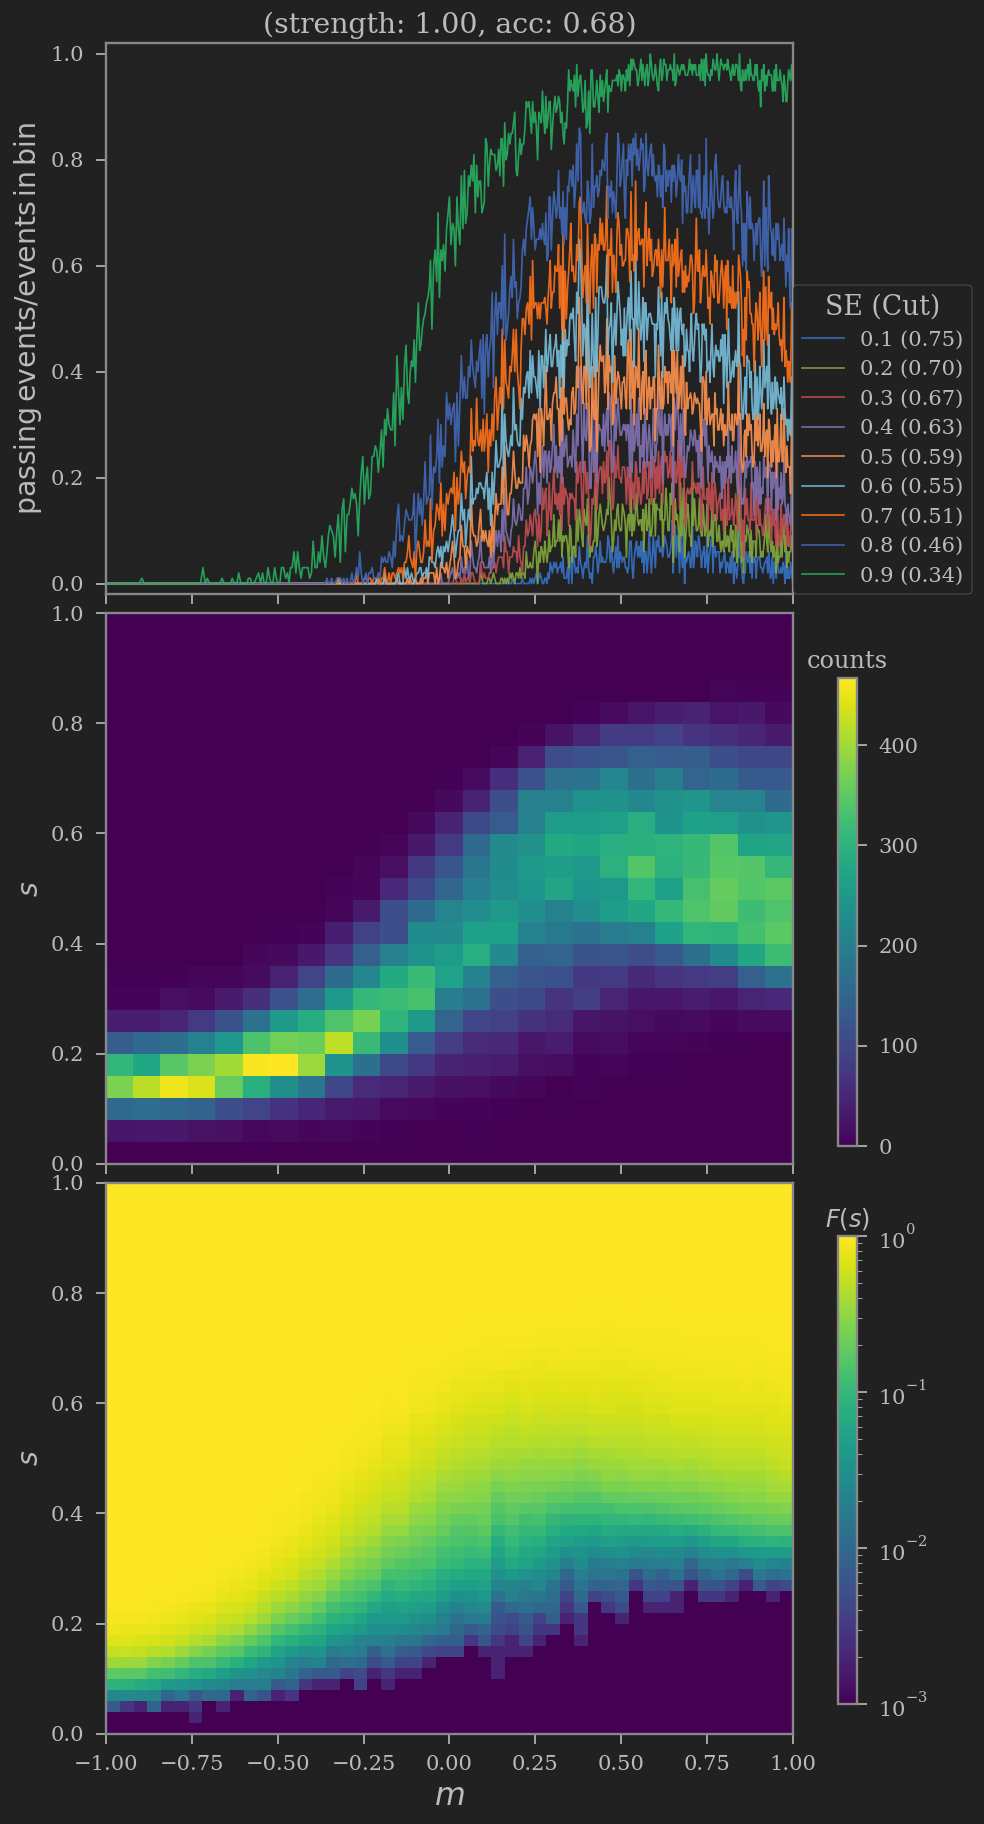

Epoch:0000/1700 || Train: loss:0.0826, acc:55% || Test: loss: 0.2476, acc:56%
Epoch:0100/1700 || Train: loss:0.0807, acc:61% || Test: loss: 0.2421, acc:62%
Epoch:0200/1700 || Train: loss:0.0793, acc:62% || Test: loss: 0.2377, acc:62%
Epoch:0300/1700 || Train: loss:0.0782, acc:63% || Test: loss: 0.2342, acc:63%
Epoch:0400/1700 || Train: loss:0.0772, acc:63% || Test: loss: 0.2314, acc:63%
Epoch:0500/1700 || Train: loss:0.0765, acc:63% || Test: loss: 0.2291, acc:63%
Epoch:0600/1700 || Train: loss:0.0759, acc:64% || Test: loss: 0.2272, acc:64%
Epoch:0700/1700 || Train: loss:0.0754, acc:64% || Test: loss: 0.2256, acc:64%
Epoch:0800/1700 || Train: loss:0.0749, acc:64% || Test: loss: 0.2243, acc:64%
Epoch:0900/1700 || Train: loss:0.0745, acc:65% || Test: loss: 0.2231, acc:64%
Epoch:1000/1700 || Train: loss:0.0741, acc:65% || Test: loss: 0.2219, acc:65%
Epoch:1100/1700 || Train: loss:0.0738, acc:65% || Test: loss: 0.2209, acc:65%
Epoch:1200/1700 || Train: loss:0.0734, acc:65% || Test: loss: 0.

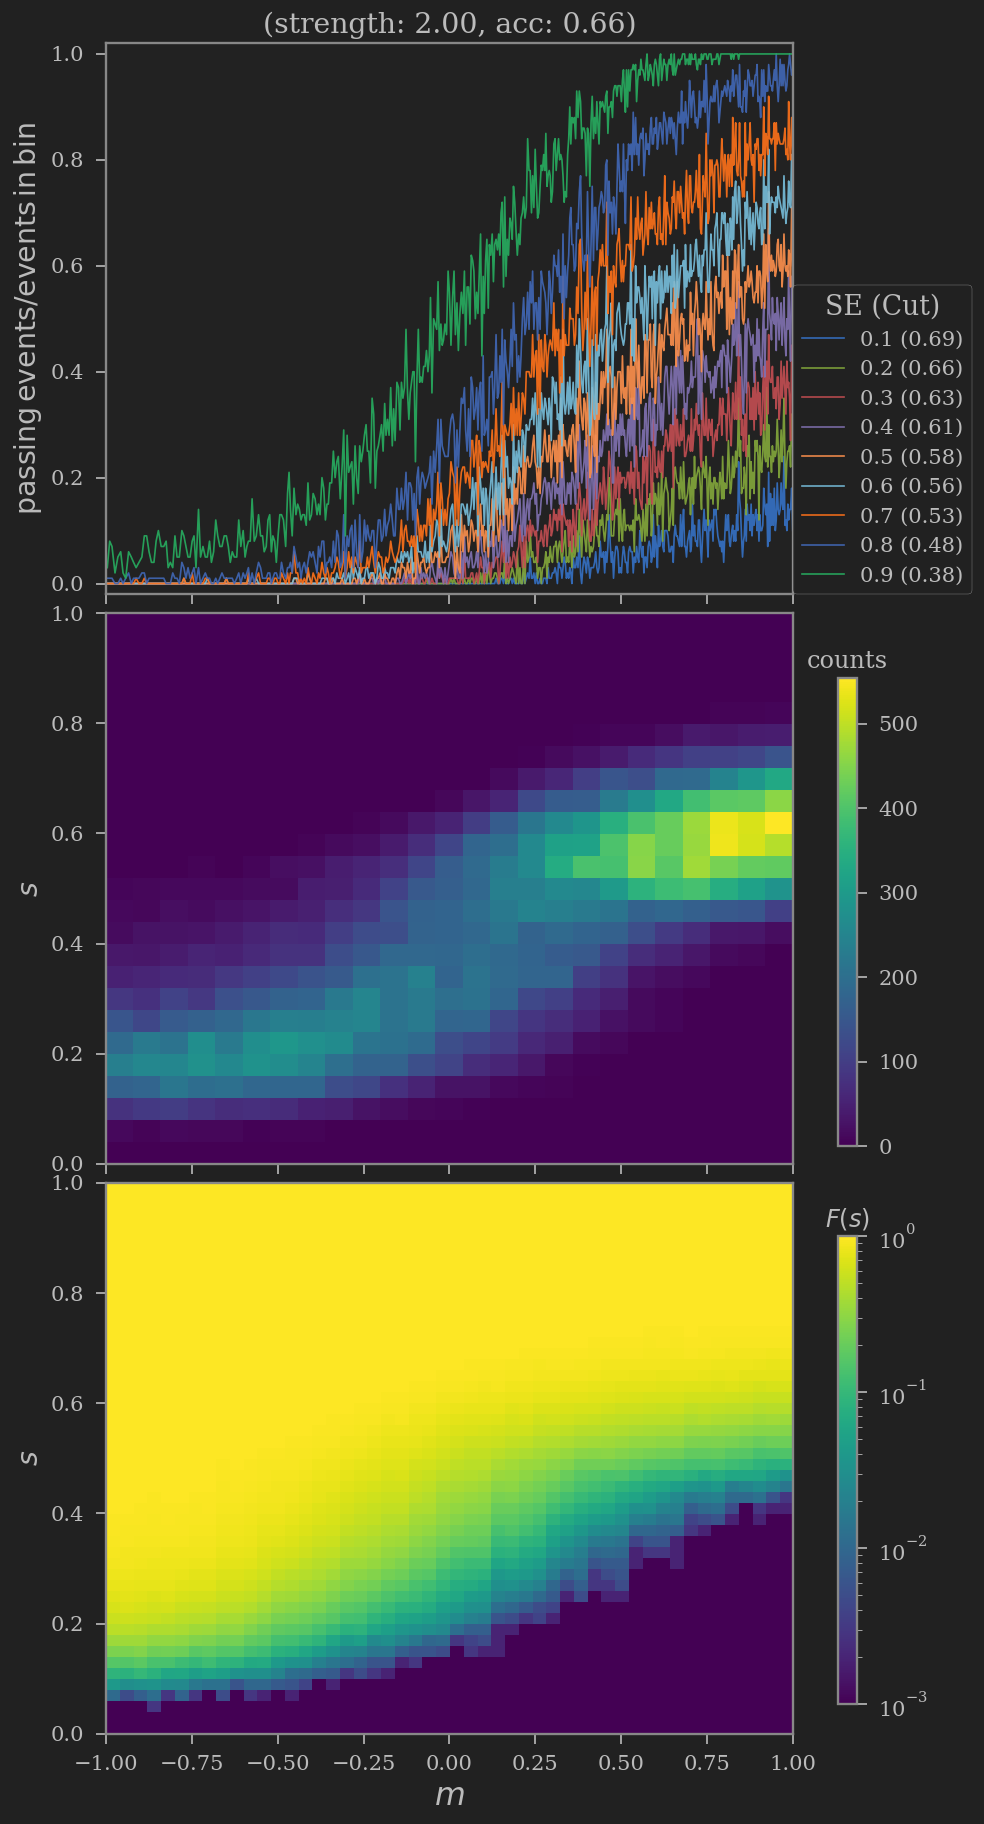

Epoch:0000/1700 || Train: loss:0.0631, acc:46% || Test: loss: 0.2524, acc:46%
Epoch:0100/1700 || Train: loss:0.0620, acc:51% || Test: loss: 0.2478, acc:52%
Epoch:0200/1700 || Train: loss:0.0611, acc:57% || Test: loss: 0.2444, acc:57%
Epoch:0300/1700 || Train: loss:0.0603, acc:63% || Test: loss: 0.2412, acc:64%
Epoch:0400/1700 || Train: loss:0.0596, acc:66% || Test: loss: 0.2381, acc:66%
Epoch:0500/1700 || Train: loss:0.0589, acc:66% || Test: loss: 0.2353, acc:66%
Epoch:0600/1700 || Train: loss:0.0582, acc:66% || Test: loss: 0.2327, acc:66%
Epoch:0700/1700 || Train: loss:0.0577, acc:66% || Test: loss: 0.2303, acc:66%
Epoch:0800/1700 || Train: loss:0.0571, acc:66% || Test: loss: 0.2281, acc:66%
Epoch:0900/1700 || Train: loss:0.0567, acc:66% || Test: loss: 0.2262, acc:66%
Epoch:1000/1700 || Train: loss:0.0563, acc:66% || Test: loss: 0.2245, acc:66%
Epoch:1100/1700 || Train: loss:0.0559, acc:66% || Test: loss: 0.2230, acc:66%
Epoch:1200/1700 || Train: loss:0.0556, acc:66% || Test: loss: 0.

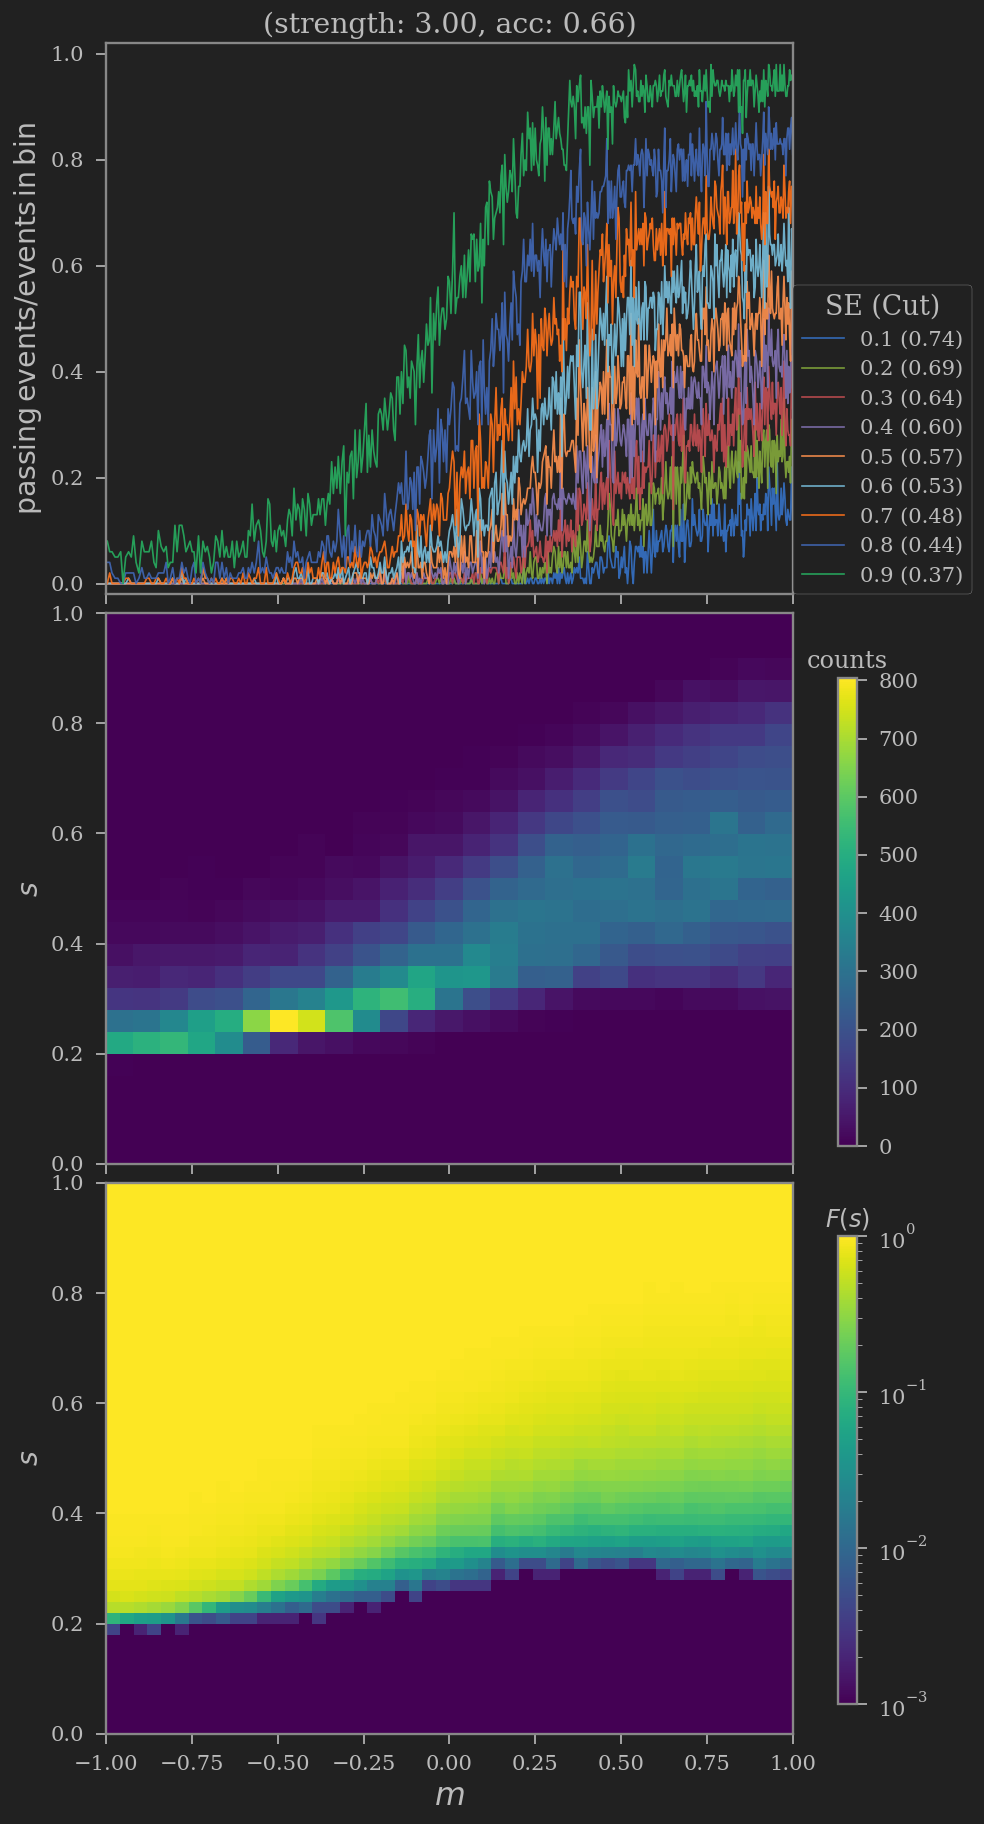

Epoch:0000/1700 || Train: loss:0.0431, acc:50% || Test: loss: 0.2582, acc:50%
Epoch:0100/1700 || Train: loss:0.0424, acc:45% || Test: loss: 0.2537, acc:45%
Epoch:0200/1700 || Train: loss:0.0420, acc:45% || Test: loss: 0.2516, acc:45%
Epoch:0300/1700 || Train: loss:0.0417, acc:51% || Test: loss: 0.2501, acc:51%
Epoch:0400/1700 || Train: loss:0.0415, acc:55% || Test: loss: 0.2488, acc:55%
Epoch:0500/1700 || Train: loss:0.0413, acc:57% || Test: loss: 0.2476, acc:57%
Epoch:0600/1700 || Train: loss:0.0411, acc:58% || Test: loss: 0.2464, acc:58%
Epoch:0700/1700 || Train: loss:0.0409, acc:59% || Test: loss: 0.2452, acc:59%
Epoch:0800/1700 || Train: loss:0.0407, acc:60% || Test: loss: 0.2439, acc:59%
Epoch:0900/1700 || Train: loss:0.0405, acc:60% || Test: loss: 0.2427, acc:60%
Epoch:1000/1700 || Train: loss:0.0403, acc:61% || Test: loss: 0.2414, acc:60%
Epoch:1100/1700 || Train: loss:0.0400, acc:61% || Test: loss: 0.2400, acc:61%
Epoch:1200/1700 || Train: loss:0.0398, acc:61% || Test: loss: 0.

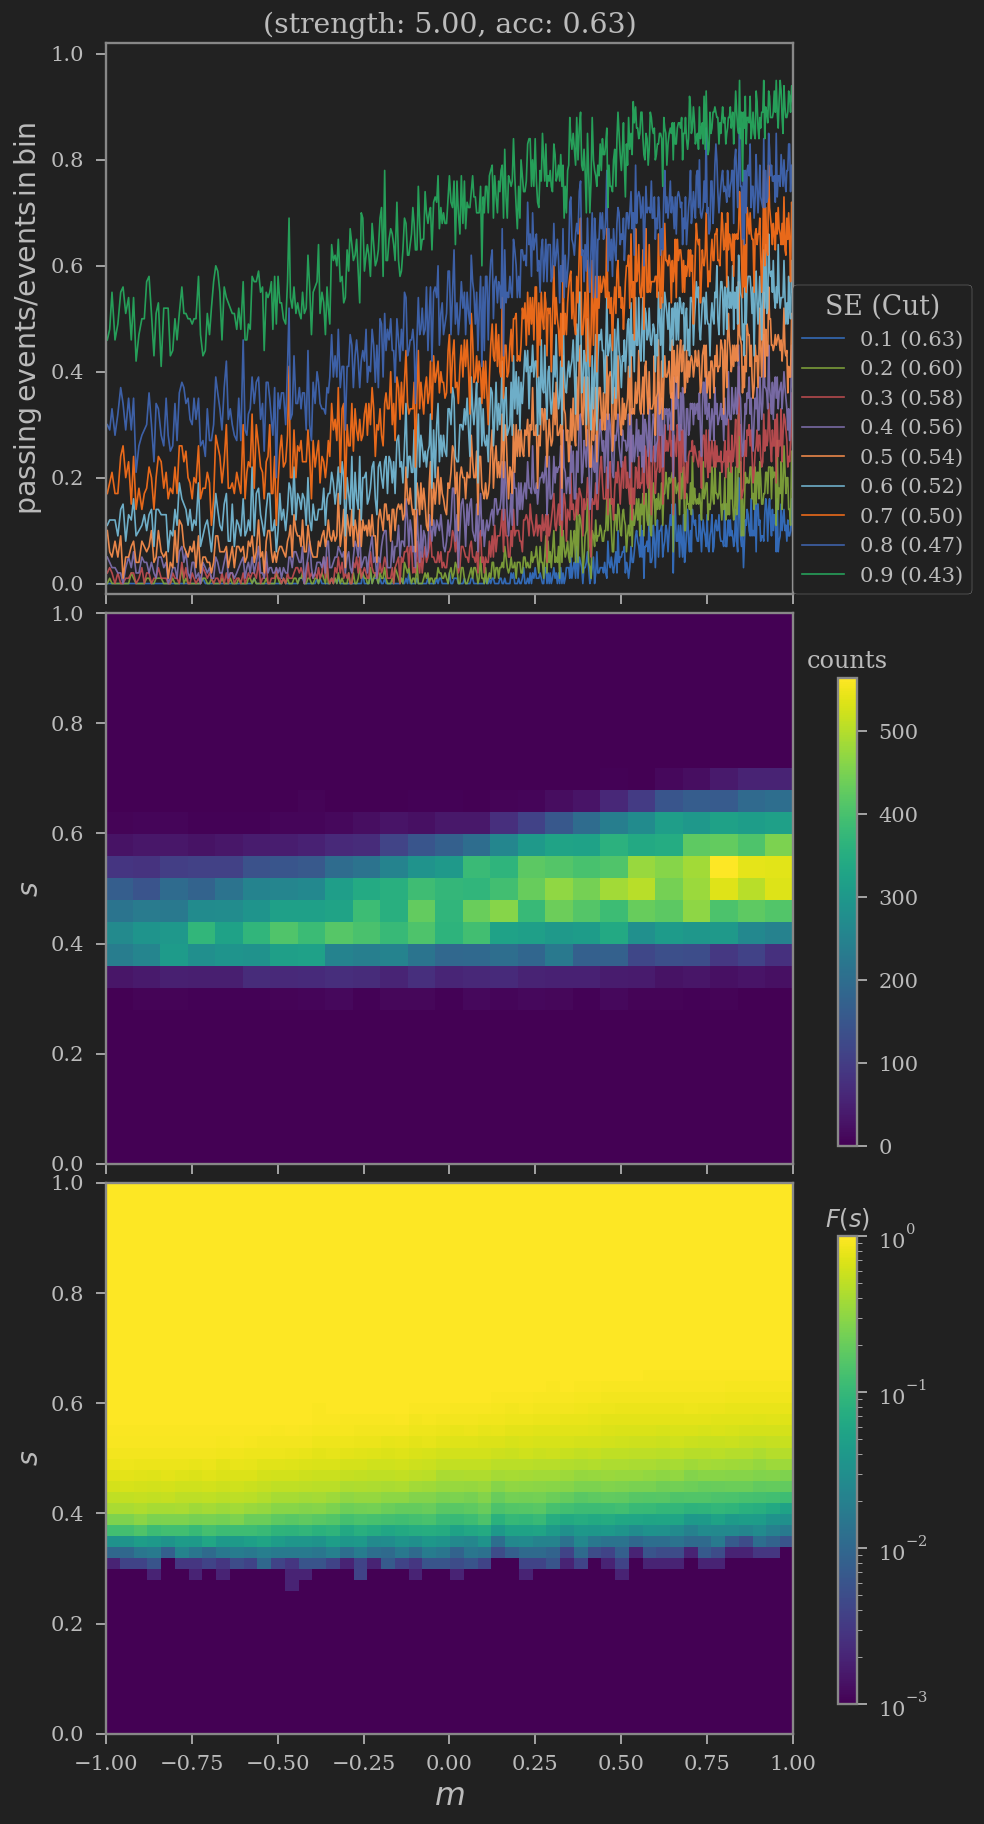

Epoch:0000/1700 || Train: loss:0.0229, acc:50% || Test: loss: 0.2515, acc:50%
Epoch:0100/1700 || Train: loss:0.0228, acc:50% || Test: loss: 0.2508, acc:50%
Epoch:0200/1700 || Train: loss:0.0228, acc:52% || Test: loss: 0.2502, acc:51%
Epoch:0300/1700 || Train: loss:0.0227, acc:53% || Test: loss: 0.2497, acc:53%
Epoch:0400/1700 || Train: loss:0.0227, acc:55% || Test: loss: 0.2492, acc:54%
Epoch:0500/1700 || Train: loss:0.0226, acc:56% || Test: loss: 0.2488, acc:56%
Epoch:0600/1700 || Train: loss:0.0226, acc:57% || Test: loss: 0.2484, acc:57%
Epoch:0700/1700 || Train: loss:0.0226, acc:58% || Test: loss: 0.2480, acc:58%
Epoch:0800/1700 || Train: loss:0.0225, acc:59% || Test: loss: 0.2476, acc:59%
Epoch:0900/1700 || Train: loss:0.0225, acc:60% || Test: loss: 0.2472, acc:60%
Epoch:1000/1700 || Train: loss:0.0225, acc:61% || Test: loss: 0.2468, acc:60%
Epoch:1100/1700 || Train: loss:0.0224, acc:61% || Test: loss: 0.2464, acc:61%
Epoch:1200/1700 || Train: loss:0.0224, acc:62% || Test: loss: 0.

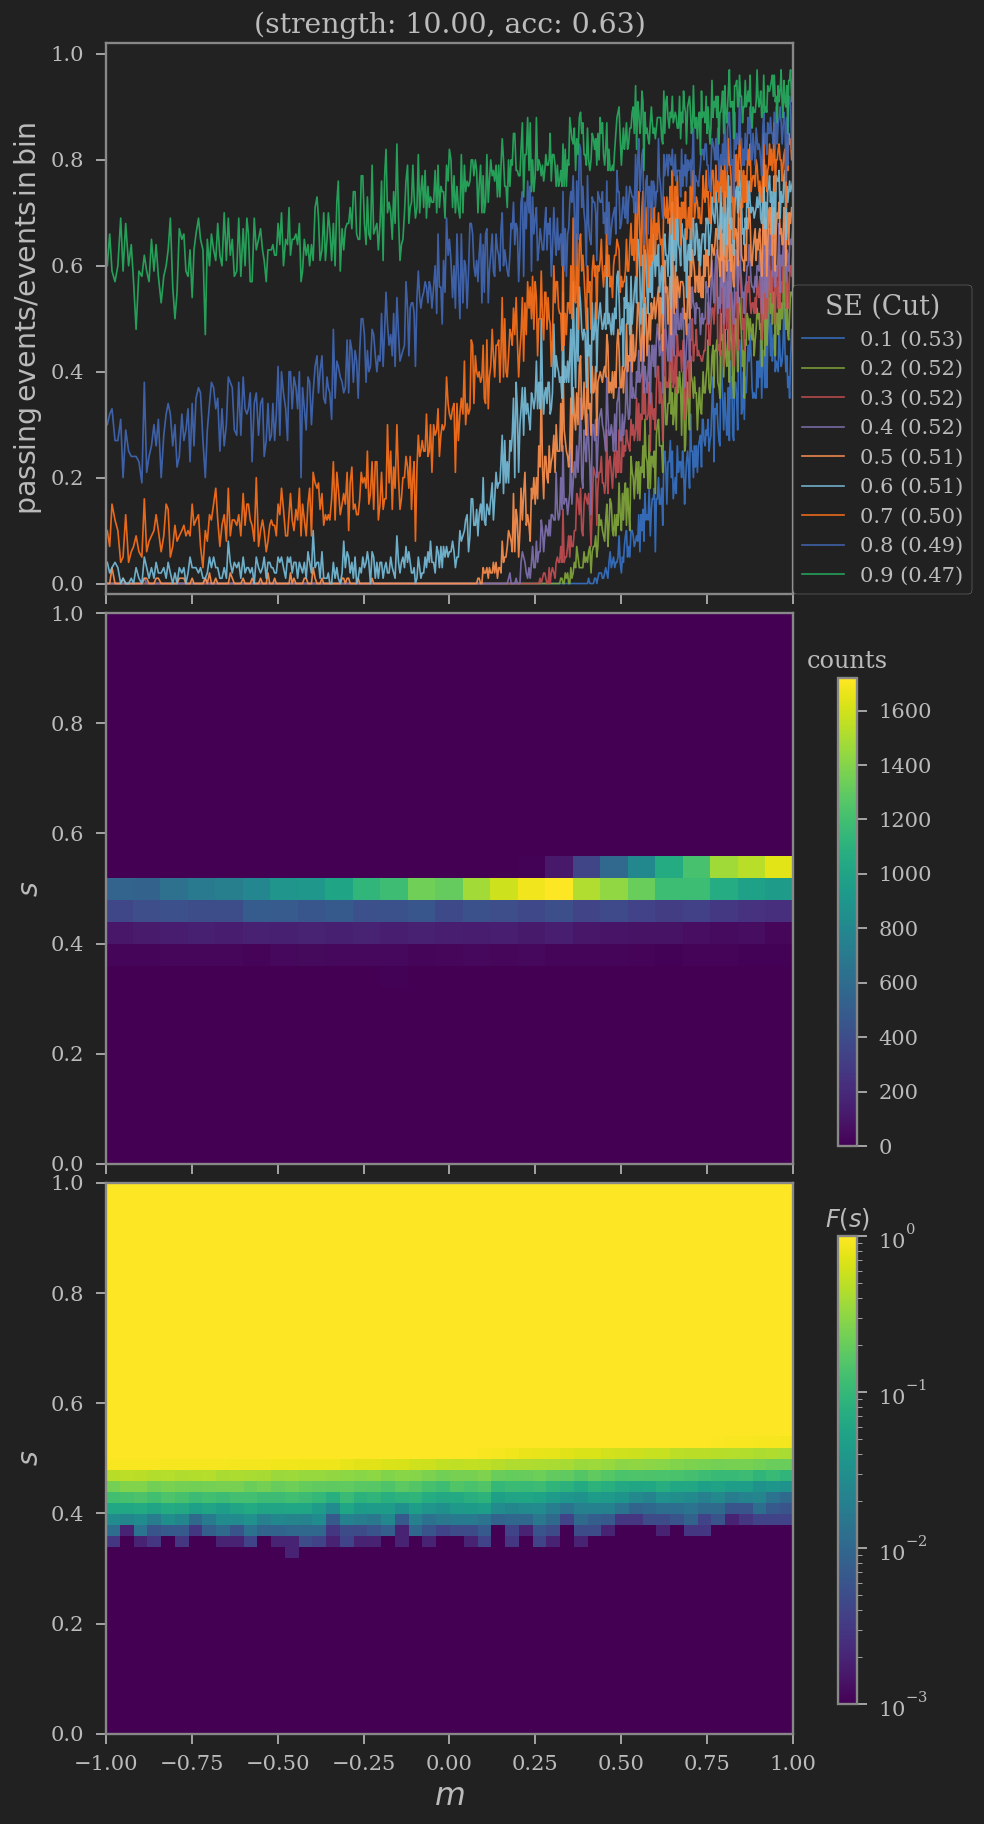

Epoch:0000/1700 || Train: loss:0.0155, acc:57% || Test: loss: 0.2479, acc:58%
Epoch:0100/1700 || Train: loss:0.0155, acc:59% || Test: loss: 0.2472, acc:60%
Epoch:0200/1700 || Train: loss:0.0154, acc:61% || Test: loss: 0.2465, acc:61%
Epoch:0300/1700 || Train: loss:0.0154, acc:61% || Test: loss: 0.2459, acc:62%
Epoch:0400/1700 || Train: loss:0.0154, acc:62% || Test: loss: 0.2452, acc:62%
Epoch:0500/1700 || Train: loss:0.0153, acc:63% || Test: loss: 0.2446, acc:63%
Epoch:0600/1700 || Train: loss:0.0153, acc:63% || Test: loss: 0.2439, acc:63%
Epoch:0700/1700 || Train: loss:0.0152, acc:63% || Test: loss: 0.2433, acc:64%
Epoch:0800/1700 || Train: loss:0.0152, acc:64% || Test: loss: 0.2426, acc:64%
Epoch:0900/1700 || Train: loss:0.0152, acc:64% || Test: loss: 0.2419, acc:64%
Epoch:1000/1700 || Train: loss:0.0151, acc:64% || Test: loss: 0.2413, acc:64%
Epoch:1100/1700 || Train: loss:0.0151, acc:64% || Test: loss: 0.2406, acc:64%
Epoch:1200/1700 || Train: loss:0.0150, acc:64% || Test: loss: 0.

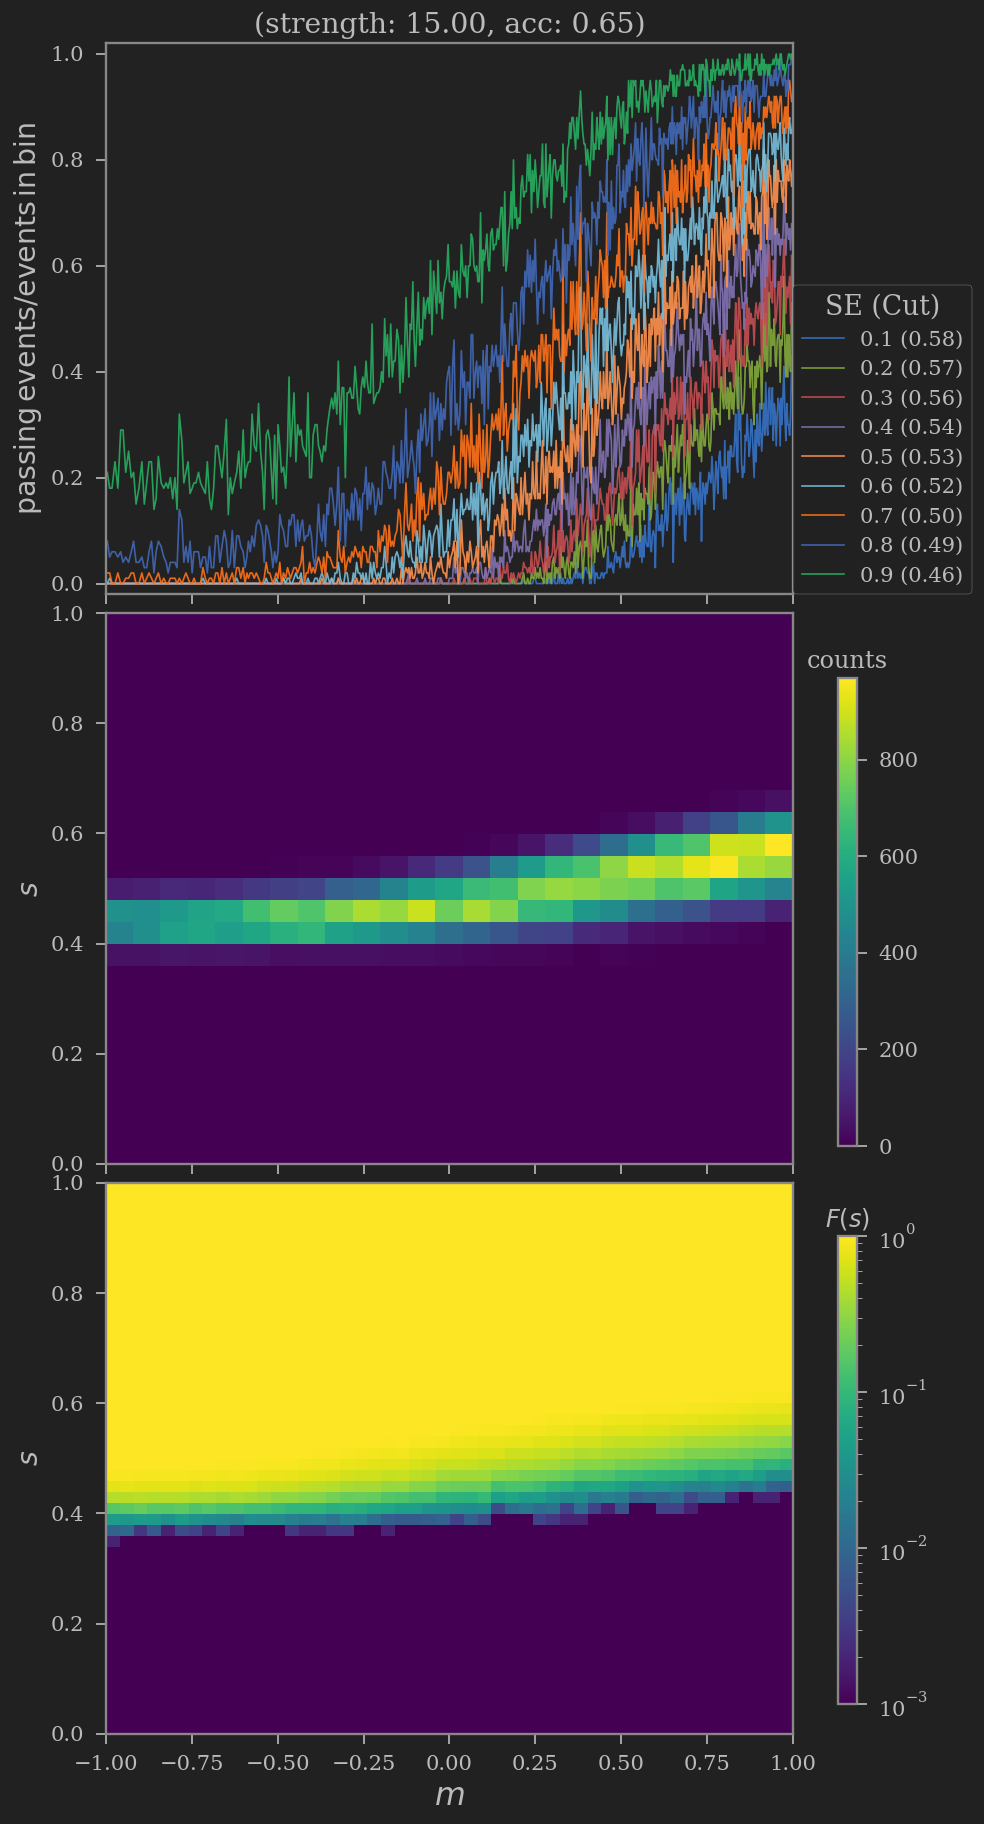

Epoch:0000/1700 || Train: loss:0.0120, acc:50% || Test: loss: 0.2521, acc:50%
Epoch:0100/1700 || Train: loss:0.0119, acc:50% || Test: loss: 0.2491, acc:50%
Epoch:0200/1700 || Train: loss:0.0118, acc:50% || Test: loss: 0.2468, acc:50%
Epoch:0300/1700 || Train: loss:0.0117, acc:53% || Test: loss: 0.2450, acc:53%
Epoch:0400/1700 || Train: loss:0.0116, acc:57% || Test: loss: 0.2436, acc:57%
Epoch:0500/1700 || Train: loss:0.0116, acc:60% || Test: loss: 0.2424, acc:60%
Epoch:0600/1700 || Train: loss:0.0115, acc:61% || Test: loss: 0.2414, acc:62%
Epoch:0700/1700 || Train: loss:0.0115, acc:63% || Test: loss: 0.2405, acc:62%
Epoch:0800/1700 || Train: loss:0.0114, acc:63% || Test: loss: 0.2397, acc:63%
Epoch:0900/1700 || Train: loss:0.0114, acc:64% || Test: loss: 0.2390, acc:63%
Epoch:1000/1700 || Train: loss:0.0114, acc:64% || Test: loss: 0.2383, acc:64%
Epoch:1100/1700 || Train: loss:0.0114, acc:64% || Test: loss: 0.2377, acc:64%
Epoch:1200/1700 || Train: loss:0.0113, acc:64% || Test: loss: 0.

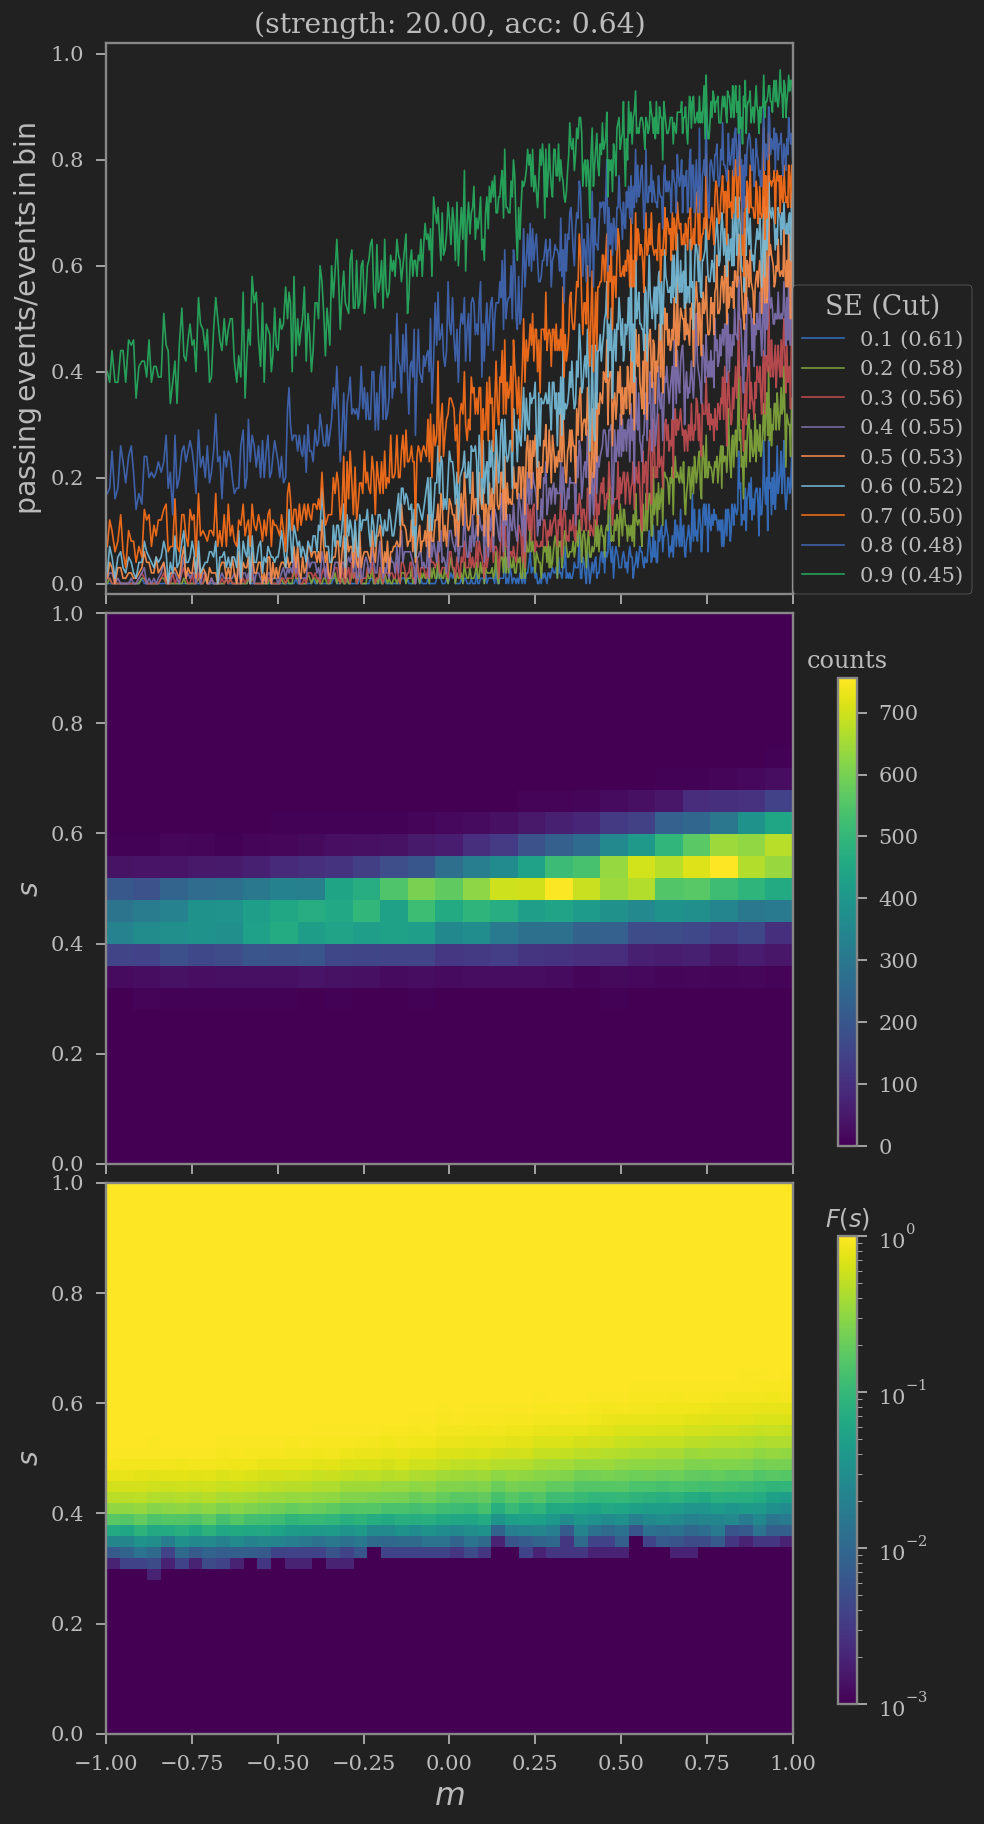

In [130]:
efficiencies = np.linspace(0.1,0.9,9)
for strength in [0,0.5,1,2,3,5,10,15,20]:
    frac = strength/(1+strength)
    metrics_train_legendre = Metrics()
    metrics_val_legendre = Metrics()
    model_legendre = Classifier()
    model_legendre.loss = LegendreLoss(frac=frac,x_biased=x_train[:,0])
    model_legendre.fit(x_train_tensor[:,1:],y_train_tensor,n_epochs=1700,
                       metrics=[metrics_train_legendre,metrics_val_legendre], 
                       val_data=[x_val_tensor[:,1:],y_val_tensor])
    
    validation_predictions = np.array(model_legendre.yhat_val.tolist()).flatten()
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(validation_predictions,(y_val==1),eff))
    
    
    scores = np.array(model_legendre(x_test_tensor[:,1:]).tolist()).reshape(-1,100)
    m = m_t.reshape(-1,100).mean(axis=1)
    F_s = []
    for s in scores.reshape(50,-1):
        density = np.histogram(s,bins=50,range=(0,1))[0]
        F_s.append(np.cumsum(density)/density.sum())
    F_s = np.array(F_s).T
    fig, [ax1, ax2, ax3]  = plt.subplots(3,1,figsize=[8,5*3],dpi=120,sharex=True)
    for j,cut in enumerate(cuts):
        c = f"C{j}" if j!= 6 else f"C11"
        passed = (scores>cut).sum(axis=1)/scores.shape[1]
        ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)

    ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=17)
    ax1.set_ylim([-0.02,1.02])
    ax1.set_title("(strength: {:.02f}, acc: {:.02})".format(strength, metrics_val_legendre.accs[-1]),fontsize=17)
    ax1.legend(loc=(1,0),markerscale=5,title="SE (Cut)",ncol=1)

    _,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=25, label="all",cmap='viridis',range=[[-1,1],[0,1]])
    cbaxes = fig.add_axes([0.86, 0.37, 0.02, 0.26]) 
    cb = plt.colorbar(h,ax=ax2,cax = cbaxes)
    cb.ax.set_title("counts")
    ax2.set_ylabel(r"$s$",fontsize=17)

    im = ax3.imshow(F_s,label="all",origin='lower',extent=[-1,1,0,1],aspect="auto",norm=LogNorm(),cmap=my_cmap)
    ax3.set_ylabel(r"$s$",fontsize=17)

    cbaxes = fig.add_axes([0.86, 0.06, 0.02, 0.26]) 
    cb = plt.colorbar(im,ax=ax3,cax = cbaxes)
    cb.ax.set_title(r"$F(s)$")
    ax3.set_xlabel(r"$m$",fontsize=19)

    fig.tight_layout(pad=0)
    plt.show()